In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import yfinance as yf
from google.colab import files
from functools import reduce
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, roc_curve, auc, confusion_matrix
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
from scipy.stats import randint
pd.set_option('display.max_columns', None)

In [2]:
# Download features from Yahoo Finance
tickers = ['GC=F', #Gold
           'SI=F', #Silver
           'PL=F', #Platinum
           'HG=F', #Copper
           'PA=F', #Palladium
           'CL=F', #Crude Oil
           'HO=F', #Heating Oil
           'NG=F', #Natural Gas
           'ZC=F', #Corn Futures
           'ZO=F', #Oat Futures
           'KE=F', #Wheat Futures
           'ZR=F', #Rough Rice Futures
           'ZL=F', #Soybean Oil Futures
           'ZS=F', #Soybean Future
           'HE=F', #Lean Hogs Futures
           'LE=F', #Live Cattle Futures
           'CC=F', #Cocoa
           'KC=F', #Coffee
           'CT=F', #Cotton
           'SB=F', #Sugar
           'XME', #Metals and mining ETF as proxy
           '^BVSP', #Brazilian equities
           '^MXX', #Mexican equities,
           'BVC.CL', #Colombian equities
           'ECH', #Chilean equitites ETF
           'USDBRL=X', #Brazilian real
           'USDCOP=X', #Colombian peso
           'USDMXN=X', #Mexican peso
           'USDCLP=X', #Chilean peso
           'EMB', #EM bond index
           'DX-Y.NYB', #dollar strength
           '^VIX', #US volatility
           '^GSPC', #S&P
           '^IRX', #13 week US
           '^FVX', #5 year US
           '^TNX', #10 year US
           '^TYX'] #30 year US

merged_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start='2010-01-01', end='2023-10-31')
    close_prices = data['Close'].rename(ticker)
    merged_data = pd.merge(merged_data, close_prices, left_index=True, right_index=True, how='outer')

print(merged_data.head())
merged_data = merged_data.reset_index(drop = False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
# Drop obvious outliers and keep only complete observations
merged_data = merged_data[(merged_data['USDCOP=X']>1700) & (merged_data['USDCLP=X'] > 400)].dropna()

In [4]:
merged_data.to_csv('/content/drive/MyDrive/Trimester 1/01_Data Science - Souza/01_Data/merged_data.csv', index=False)

In [5]:
merged_data = pd.read_csv('/content/drive/MyDrive/Trimester 1/01_Data Science - Souza/01_Data/merged_data.csv')

In [7]:
### Plot indexed exchange rates against USD on same graph ###

# Create a copy of merged_data for plotting
df_plot = merged_data.copy()
df_plot.set_index('Date', inplace=True)

currencies = ['USDBRL=X', 'USDCOP=X', 'USDMXN=X', 'USDCLP=X']
labels = ['Brazilian Real per USD', 'Colombian Peso per USD', 'Mexican Peso per USD', 'Chilean Peso per USD']

fig = go.Figure()
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (currency, label) in enumerate(zip(currencies, labels)):
    # Index each currency to 100 on the initial date
    base_value = df_plot.loc[df_plot.index[0], currency]
    normalized_values = df_plot[currency] / base_value * 100

    # Add trace for each currency
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=normalized_values,
        mode='lines',
        name=label,
        line=dict(color=color_palette[i])
    ))

# Modify layout
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Exchange Rate (Indexed Jan 2010 = 100)",
    showlegend=True,
    legend=dict(x=.2, y=.975, traceorder='normal', orientation='v'),
    margin=dict(l=10, r=10, t=10, b=10),
    width=1200,
    height=800,
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridwidth=1),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='black'),
     font=dict(family="Times New Roman", size=19)
)

fig.show()


In [8]:
### Create density plots for returns of each currency on the same graph ###

# Create a copy of merged_data for plotting
df_plot = merged_data.copy()
df_plot.set_index('Date', inplace=True)

# Calculate percent change for each currency
df_plot[currencies] = df_plot[currencies].pct_change()

# Create a list of arrays, each containing the percent changes of a currency
hist_data = [df_plot[currency].dropna().values for currency in currencies]

color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create the distribution plot
fig = ff.create_distplot(hist_data, labels, bin_size=.0005, show_rug=False, show_hist=False, colors=color_palette)

# Modify layout
fig.update_layout(
    xaxis_title="Percent change from previous day",
    yaxis_title="Frequency",
    showlegend=True,
    legend=dict(x=.2, y=.975, traceorder='normal', orientation='v'),
    margin=dict(l=10, r=10, t=10, b=10),
    width=1200,
    height=800,
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='black',
        tickformat='.0%'
    ),
    yaxis=dict(
        showgrid=False
    ),
    font=dict(family="Times New Roman", size=19)
)

fig.show()


**Direction of currency change classifiers**

In [9]:
### Generate training and testing datasets for each currency ###

X_train = {}
Y_train = {}
X_test  = {}
Y_test  = {}
currencies = ['USDBRL=X', 'USDCOP=X', 'USDMXN=X', 'USDCLP=X']

for currency in currencies:
  df = merged_data.copy()

  # Turn all features into percent changes
  df = df.drop(columns=['Date']).pct_change()

  # Turn target variable into a binary
  # An increase in the exchange rate is a depreciation
  df[currency] = (df[currency] > 0).astype(int)

  # Add date back on
  df = pd.concat([merged_data['Date'], df], axis=1)

  # Shift currency so we are predicting the next day's percent change using features from the day before
  df[currency] = df[currency].shift(-1)
  df['Date'] = df['Date'].shift(-1)

  # Drop resulting NAs
  df = df.dropna()

  # Split train and testing data at 2023-01-01
  train = df[df['Date'] < '2023-01-01'].drop(columns = {'Date'})
  test  = df[df['Date'] >= '2023-01-01'].drop(columns = {'Date'})

  # Apply minmax scalar to all features
  scaler = MinMaxScaler()

  X_train[currency] = scaler.fit_transform(train.drop(columns = currency))
  Y_train[currency] = train[[currency]]
  X_test[currency] = scaler.fit_transform(test.drop(columns = currency))
  Y_test[currency] = test[[currency]]

In [14]:
# Look at the means for the target variable
print(np.mean(Y_train['USDBRL=X']))
print(np.mean(Y_train['USDMXN=X']))
print(np.mean(Y_train['USDCOP=X']))
print(np.mean(Y_train['USDCLP=X']))
print(" ")
print(np.mean(Y_test['USDBRL=X']))
print(np.mean(Y_test['USDMXN=X']))
print(np.mean(Y_test['USDCOP=X']))
print(np.mean(Y_test['USDCLP=X']))

USDBRL=X    0.514353
dtype: float64
USDMXN=X    0.491388
dtype: float64
USDCOP=X    0.475515
dtype: float64
USDCLP=X    0.496116
dtype: float64
 
USDBRL=X    0.463542
dtype: float64
USDMXN=X    0.416667
dtype: float64
USDCOP=X    0.401042
dtype: float64
USDCLP=X    0.494792
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old

**Elastic Net classifier**

In [ ]:
### Define elastic net classifier function that will return the model with the best hyperparameters from the random search ###
def tune_logistic_regression(X_train, X_test, Y_train, Y_test):
    rs_space_lr = {
        'C': np.logspace(-4, 4, 100),
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': np.linspace(0, 1, 100),
        'max_iter': [5000],
    }

    logistic_regression = LogisticRegression()

    tscv = TimeSeriesSplit(n_splits=10)
    random_search_lr = RandomizedSearchCV(logistic_regression, param_distributions=rs_space_lr, cv=tscv, scoring='accuracy', random_state=33)
    random_search_lr.fit(X_train, Y_train.values.ravel())

    best_params_lr = random_search_lr.best_params_
    print("Best Parameters from Random Search:", best_params_lr)

    best_lr = LogisticRegression(**best_params_lr)
    best_lr.fit(X_train, Y_train.values.ravel())

    return best_lr

In [ ]:
### Run elastic net classifier function on all currencies and store best models ###
best_lr = {}

for currency in currencies:
  print('Tuning logistic regression for', currency)
  best_lr[currency] = tune_logistic_regression(X_train[currency], X_test[currency], Y_train[currency], Y_test[currency])

Tuning logistic regression for USDBRL=X
Best Parameters from Random Search: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': 0.888888888888889, 'C': 54.62277217684348}
Tuning logistic regression for USDCOP=X
Best Parameters from Random Search: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': 0.06060606060606061, 'C': 351.11917342151344}
Tuning logistic regression for USDMXN=X
Best Parameters from Random Search: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': 0.06060606060606061, 'C': 351.11917342151344}
Tuning logistic regression for USDCLP=X
Best Parameters from Random Search: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': 0.48484848484848486, 'C': 4.862601580065354}


**Random Forest classifier**

In [ ]:
### Define Random Forest classifier function that will return the model with the best hyperparameters from the random search ###
def tune_rf_classifier(X_train, X_test, Y_train, Y_test):

  rf = RandomForestClassifier()
  rs_space_rf ={'max_depth':list(np.arange(10, 100, step=10)) + [None],
                'n_estimators':[500],
                'max_features':randint(2,6),
                'criterion':['gini','entropy'],
                'min_samples_leaf':randint(1,4),
                'min_samples_split':np.arange(2, 10, step=2)
                }

  tscv = TimeSeriesSplit(n_splits=10)
  random_search_rf = RandomizedSearchCV(rf, rs_space_rf, cv=tscv, scoring='accuracy', n_jobs=-1, random_state=33)
  random_search_rf.fit(X_train, Y_train.values.ravel())

  best_params_rf = random_search_rf.best_params_
  print("Best Hyperparameters:", best_params_rf)

  best_rf = random_search_rf.best_estimator_

  return best_rf

In [ ]:
### Run Random Forest classifier function on all currencies and store best models ###
best_rf = {}

for currency in currencies:
  print('Tuning Random Forest Classifier for', currency)
  best_rf[currency] = tune_rf_classifier(X_train[currency], X_test[currency], Y_train[currency], Y_test[currency])

Tuning Random Forest Classifier for USDBRL=X
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}
Tuning Random Forest Classifier for USDCOP=X
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 70, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Tuning Random Forest Classifier for USDMXN=X
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}
Tuning Random Forest Classifier for USDCLP=X
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}


**Gradient Boost classifier**

In [ ]:
### Define Gradient Boost classifier function that will return the model with the best hyperparameters from the random search ###
def tune_gb_classifier(X_train, X_test, Y_train, Y_test):

  rs_space_gb = {
      'n_estimators': [500],
      'learning_rate': np.arange(0.01, 0.31, 0.1),
      'max_depth': np.arange(3, 10),
      'subsample': np.arange(0.8, 1.01, 0.1),
      'min_samples_split': np.arange(2, 6),
      'min_samples_leaf': np.arange(1, 6),
      'max_features': randint(2,6)
  }

  gb = GradientBoostingClassifier(random_state=33)
  tscv = TimeSeriesSplit(n_splits=10)
  random_search_gb = RandomizedSearchCV(gb, param_distributions=rs_space_gb, cv=tscv, scoring='accuracy', random_state=33)
  random_search_gb.fit(X_train, Y_train.values.ravel())

  best_params_gb = random_search_gb.best_params_
  print("Best Hyperparameters:", best_params_gb)

  best_gb = random_search_gb.best_estimator_

  return best_gb

In [ ]:
### Run Gradient Boost classifier function on all currencies and store best models ###
best_gb = {}

for currency in currencies:
  print('Tuning Gradient Boosting Classifier for', currency)
  best_gb[currency] = tune_gb_classifier(X_train[currency], X_test[currency], Y_train[currency], Y_test[currency])

Tuning Gradient Boosting Classifier for USDBRL=X
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500, 'subsample': 0.9}
Tuning Gradient Boosting Classifier for USDCOP=X
Best Hyperparameters: {'learning_rate': 0.21000000000000002, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500, 'subsample': 1.0}
Tuning Gradient Boosting Classifier for USDMXN=X
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 1.0}
Tuning Gradient Boosting Classifier for USDCLP=X
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500, 'subsample': 0.9}


In [ ]:
### Define MLP classifier function that will return the model with the best hyperparameters from the random search ###
def tune_mlp_classifier(X_train, X_test, Y_train, Y_test):
    rs_space_mlp = {
      'hidden_layer_sizes': [(50,50,),(50,),(100,100,)],
      'activation': ['relu'],
      'solver': ['adam'],
      'alpha': np.logspace(-5, 3, 9),
      'learning_rate': ['adaptive'],
      'max_iter': [1000],
    }

    mlp = MLPClassifier(random_state = 33)

    tscv = TimeSeriesSplit(n_splits=10)
    random_search_mlp = RandomizedSearchCV(mlp, param_distributions=rs_space_mlp, cv=tscv, scoring='accuracy', n_jobs=-1, random_state=33)
    random_search_mlp.fit(X_train, Y_train.values.ravel())

    best_params_mlp = random_search_mlp.best_params_
    print("Best Hyperparameters:", best_params_mlp)

    best_mlp = MLPClassifier(**best_params_mlp, random_state=33)
    best_mlp.fit(X_train, Y_train.values.ravel())

    return best_mlp

In [ ]:
### Run MLP classifier function on all currencies and store best models ###
best_mlp = {}

for currency in currencies:
  print('Tuning MLP Classifier for', currency)
  best_mlp[currency] = tune_mlp_classifier(X_train[currency], X_test[currency], Y_train[currency], Y_test[currency])

Tuning MLP Classifier for USDBRL=X
Best Hyperparameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 1.0, 'activation': 'relu'}
Tuning MLP Classifier for USDCOP=X
Best Hyperparameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 1e-05, 'activation': 'relu'}
Tuning MLP Classifier for USDMXN=X
Best Hyperparameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 1e-05, 'activation': 'relu'}
Tuning MLP Classifier for USDCLP=X
Best Hyperparameters: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}


In [ ]:
# Save out all models
currencies = ['USDBRL=X', 'USDCOP=X', 'USDMXN=X', 'USDCLP=X']

base_directory = '/content/drive/MyDrive/Trimester 1/01_Data Science - Souza/02_Models/'
for currency in currencies:
  file_path_lr = os.path.join(base_directory, f'acc_lr_{currency}.pickle')
  pickle.dump(best_lr[currency], open(file_path_lr, 'wb'))

  file_path_rf = os.path.join(base_directory, f'acc_rf_{currency}.pickle')
  pickle.dump(best_rf[currency], open(file_path_rf, 'wb'))

  file_path_gb = os.path.join(base_directory, f'acc_gb_{currency}.pickle')
  pickle.dump(best_gb[currency], open(file_path_gb, 'wb'))

  file_path_mlp = os.path.join(base_directory, f'acc_mlp_{currency}.pickle')
  pickle.dump(best_mlp[currency], open(file_path_mlp, 'wb'))

In [10]:
# Load all models in
currencies = ['USDBRL=X', 'USDCOP=X', 'USDMXN=X', 'USDCLP=X']
best_lr = {}
best_rf = {}
best_gb = {}
best_mlp = {}

base_directory = '/content/drive/MyDrive/Trimester 1/01_Data Science - Souza/02_Models/'
for currency in currencies:
  file_path_lr = os.path.join(base_directory, f'acc_lr_{currency}.pickle')
  best_lr[currency] = pickle.load(open(file_path_lr, 'rb'))

  file_path_rf = os.path.join(base_directory, f'acc_rf_{currency}.pickle')
  best_rf[currency] = pickle.load(open(file_path_rf, 'rb'))

  file_path_gb = os.path.join(base_directory, f'acc_gb_{currency}.pickle')
  best_gb[currency] = pickle.load(open(file_path_gb, 'rb'))

  file_path_mlp = os.path.join(base_directory, f'acc_mlp_{currency}.pickle')
  best_mlp[currency] = pickle.load(open(file_path_mlp, 'rb'))


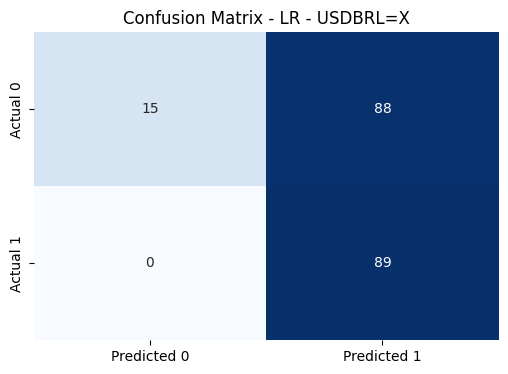

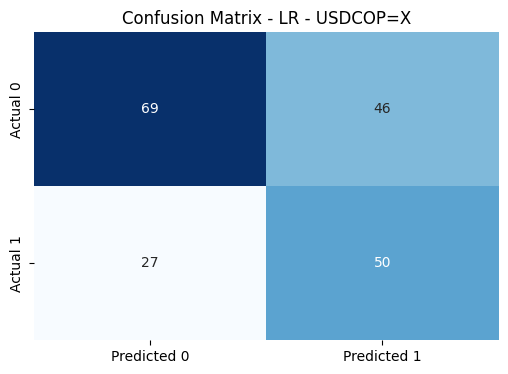

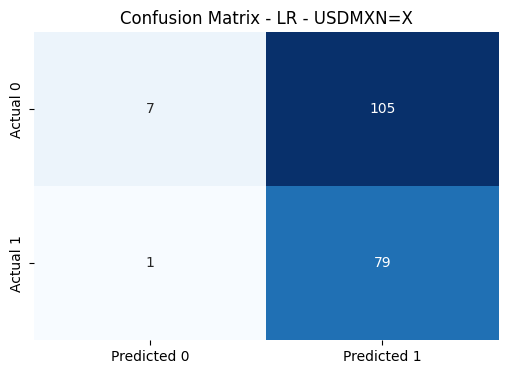

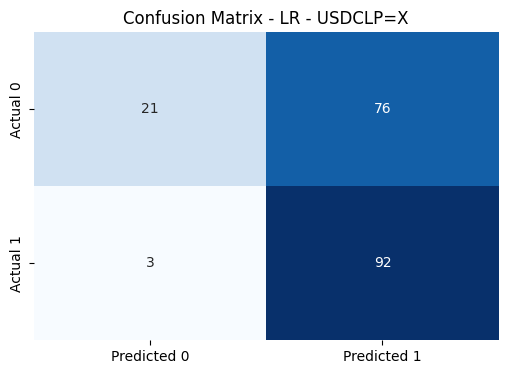

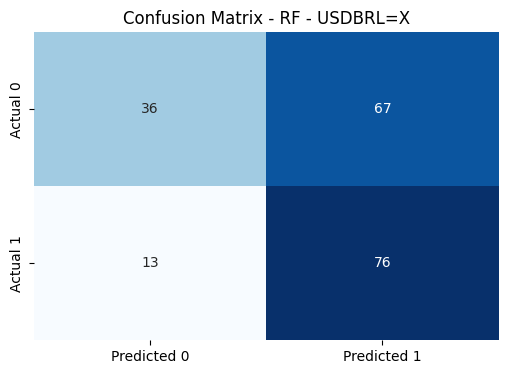

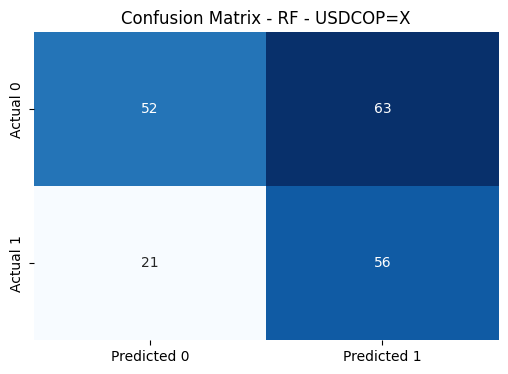

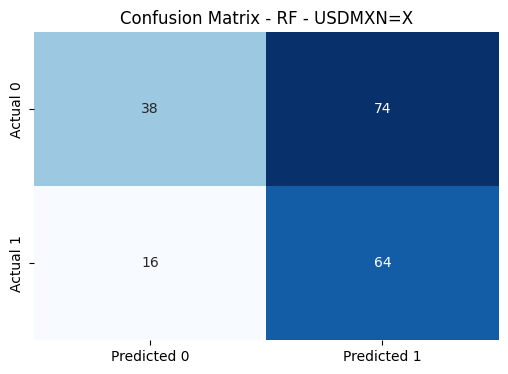

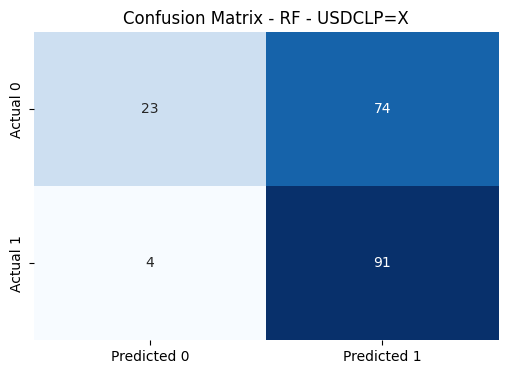

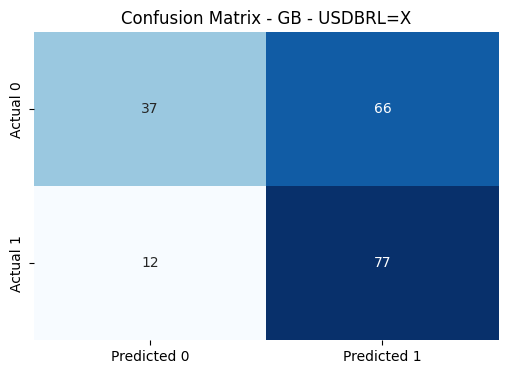

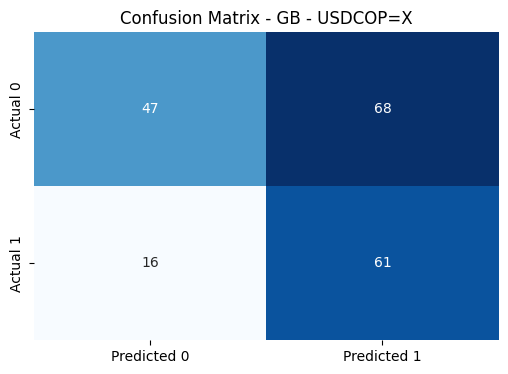

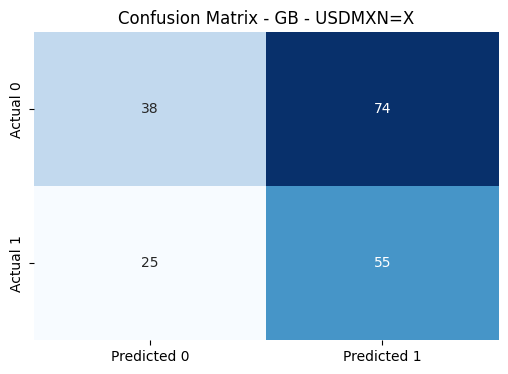

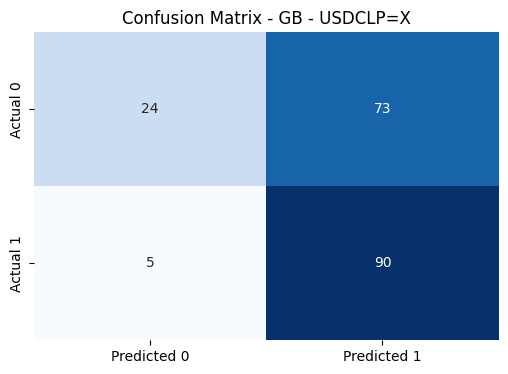

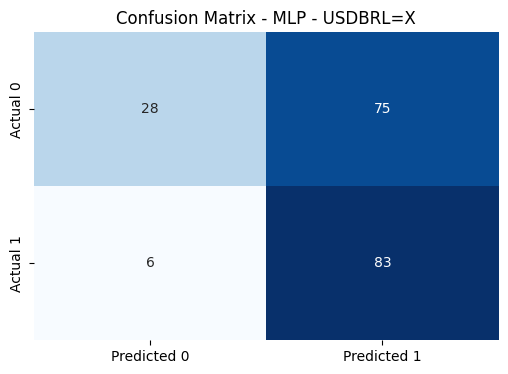

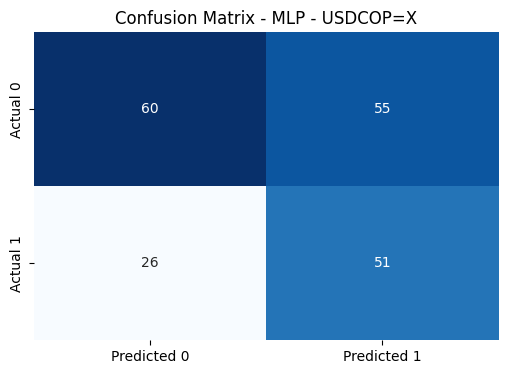

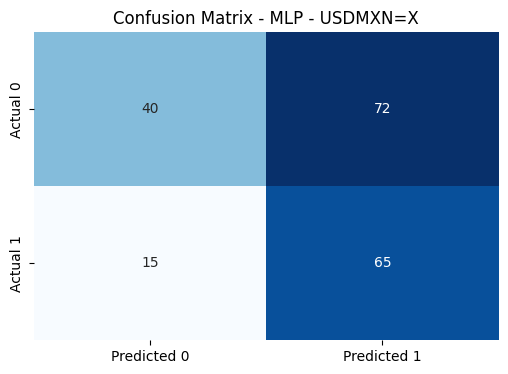

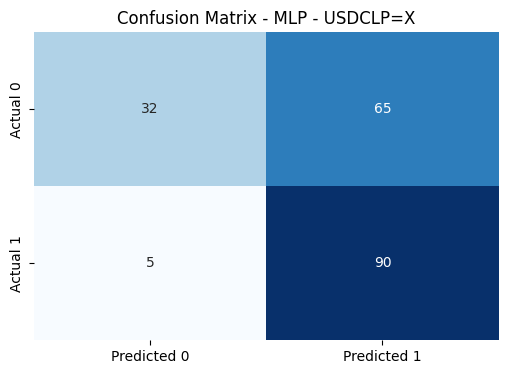

   Model Type  Currency  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0          LR  USDBRL=X  0.541667   0.502825  1.000000  0.669173  0.783244
1          LR  USDCOP=X  0.619792   0.520833  0.649351  0.578035  0.683004
2          LR  USDMXN=X  0.447917   0.429348  0.987500  0.598485  0.656027
3          LR  USDCLP=X  0.588542   0.547619  0.968421  0.699620  0.760825
4          RF  USDBRL=X  0.583333   0.531469  0.853933  0.655172  0.743646
5          RF  USDCOP=X  0.562500   0.470588  0.727273  0.571429  0.650480
6          RF  USDMXN=X  0.531250   0.463768  0.800000  0.587156  0.662277
7          RF  USDCLP=X  0.593750   0.551515  0.957895  0.700000  0.749756
8          GB  USDBRL=X  0.593750   0.538462  0.865169  0.663793  0.753245
9          GB  USDCOP=X  0.562500   0.472868  0.792208  0.592233  0.656239
10         GB  USDMXN=X  0.484375   0.426357  0.687500  0.526316  0.533482
11         GB  USDCLP=X  0.593750   0.552147  0.947368  0.697674  0.719805
12        MLP  USDBRL=X  

In [11]:
### Generate summary table for test performance ###

# Define the model types and currencies
model_types = ['LR', 'RF', 'GB', 'MLP']
currencies = ['USDBRL=X', 'USDCOP=X', 'USDMXN=X', 'USDCLP=X']

# Initialize lists
dfs = []
confusion_matrices = []
mean_pred = []

# Iterate through each model type
for model_type in model_types:
  # Iterate through each currency
  for currency in currencies:
    if model_type == 'LR':
        model = best_lr[currency]
    elif model_type == 'RF':
        model = best_rf[currency]
    elif model_type == 'GB':
        model = best_gb[currency]
    elif model_type == 'MLP':
        model = best_mlp[currency]

    # Make predictions on the test data
    Y_pred = model.predict(X_test[currency])

    cm = confusion_matrix(Y_test[currency], Y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_type} - {currency}')
    plt.show()
    confusion_matrices.append((model_type, currency, cm))

    mean_pred.append((model_type, currency, np.mean(Y_pred)))

    # Calculate performance metrics
    accuracy = accuracy_score(Y_test[currency], Y_pred)
    precision = precision_score(Y_test[currency], Y_pred)
    recall = recall_score(Y_test[currency], Y_pred)
    f1 = f1_score(Y_test[currency], Y_pred)
    auc_roc = roc_auc_score(Y_test[currency], model.predict_proba(X_test[currency])[:, 1])

    result_df = pd.DataFrame({
        'Model Type': model_type,
        'Currency': currency,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }, index=[0])

    dfs.append(result_df)

summary_df = pd.concat(dfs, ignore_index=True)
print(summary_df)


In [83]:
# Map the model type abbreviations to friendly names
model_type_mapping = {
    'LR': 'Elastic Net',
    'RF': 'Random Forest',
    'GB': 'Gradient Boost',
    'MLP': 'MLP'
}
summary_df['Model Type'] = summary_df['Model Type'].map(model_type_mapping)

# Map the currency codes
currency_mapping = {
    'USDBRL=X': 'Brazilian Real',
    'USDCOP=X': 'Colombian Peso',
    'USDMXN=X': 'Mexican Peso',
    'USDCLP=X': 'Chilean Peso'
}
summary_df['Currency'] = summary_df['Currency'].map(currency_mapping)

dark2_colors = ['#1B9E77', '#D95F02', '#7570B3', '#E7298A']

# Generate bar chart for accuracy, grouped by currency
fig = px.bar(
    summary_df,
    x='Currency',
    y='Accuracy',
    color='Model Type',
    barmode='group',
    color_discrete_sequence=dark2_colors
)

# Update layout
fig.update_layout(
    xaxis_title='Currency',
    yaxis=dict(
        title='Accuracy',
        tickformat=',.0%',
        gridcolor='Black'
    ),
    legend_title='Model',
    legend=dict(
        x=1,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='Black'
    ),
    plot_bgcolor='white',
    bargap=0.15,
    width=800,
    font=dict(family="Times New Roman", size=14),
    margin=dict(t=10, b=10, l=10, r=10)
)

fig.update_traces(texttemplate='')
fig.show()


In [54]:
### Function to plot ROC curve ###
def plot_curr_roc(currency):
  ## Predict probabilities for positive class on the test set across models ###
  Y_prob_lr = best_lr[currency].predict_proba(X_test[currency])[:, 1]
  fpr_lr, tpr_lr, _ = roc_curve(Y_test[currency], Y_prob_lr)
  roc_auc_lr = auc(fpr_lr, tpr_lr)

  Y_prob_rf = best_rf[currency].predict_proba(X_test[currency])[:, 1]
  fpr_rf, tpr_rf, _ = roc_curve(Y_test[currency], Y_prob_rf)
  roc_auc_rf = auc(fpr_rf, tpr_rf)

  Y_prob_gb = best_gb[currency].predict_proba(X_test[currency])[:, 1]
  fpr_gb, tpr_gb, _ = roc_curve(Y_test[currency], Y_prob_gb)
  roc_auc_gb = auc(fpr_gb, tpr_gb)

  Y_prob_mlp = best_mlp[currency].predict_proba(X_test[currency])[:, 1]
  fpr_mlp, tpr_mlp, _ = roc_curve(Y_test[currency], Y_prob_mlp)
  roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

  # Define the title based on the currency
  titles = {
      'USDMXN=X': 'Mexican Peso',
      'USDCOP=X': 'Colombian Peso',
      'USDCLP=X': 'Chilean Peso',
      'USDBRL=X': 'Brazilian Real'
  }

  dark2_colors = ['#1B9E77', '#D95F02', '#7570B3', '#E7298A']

  # Create traces for the ROC curves by model
  traces = [
      go.Scatter(x=fpr_lr, y=tpr_lr, mode='lines', name=f'Elastic net (AUC = {roc_auc_lr:.2f})', line=dict(color=dark2_colors[0])),
      go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines', name=f'Random Forest (AUC = {roc_auc_rf:.2f})', line=dict(color=dark2_colors[1])),
      go.Scatter(x=fpr_gb, y=tpr_gb, mode='lines', name=f'Gradient Boost (AUC = {roc_auc_gb:.2f})', line=dict(color=dark2_colors[2])),
      go.Scatter(x=fpr_mlp, y=tpr_mlp, mode='lines', name=f'MLP (AUC = {roc_auc_mlp:.2f})', line=dict(color=dark2_colors[3])),
      go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', line=dict(color='grey', dash='dash'))
  ]

  # Update layout
  layout = go.Layout(
      title={
        'text': f'{titles.get(currency, "Selected Currency")}',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
      },
      xaxis=dict(title='False Positive Rate', showgrid=False, zeroline=False, range=[-0.05, 1.05]),
      yaxis=dict(title='True Positive Rate', showgrid=False, zeroline=False, range=[-0.05, 1.05]),
      shapes=[
          # x-axis line
          {'type': 'line', 'x0': 0, 'y0': 0, 'x1': 1, 'y1': 0, 'line': {'color': 'black', 'width': 2}},
          # y-axis line
          {'type': 'line', 'x0': 0, 'y0': 0, 'x1': 0, 'y1': 1, 'line': {'color': 'black', 'width': 2}},
      ],
      font=dict(family='Times New Roman', size=16),
      showlegend=True,
      legend=dict(x=.1, y=.95, bgcolor='rgba(255,255,255,0.5)'),
      plot_bgcolor='white',
      width=700,
      height=700,
      margin=dict(t=60, b=10, l=10, r=10)
  )

  fig = go.Figure(data=traces, layout=layout)
  fig.show()

In [57]:
plot_curr_roc('USDBRL=X')

In [58]:
plot_curr_roc('USDMXN=X')

In [59]:
plot_curr_roc('USDCOP=X')

In [61]:
plot_curr_roc('USDCLP=X')

In [ ]:
feature_importances = best_gb['USDMXN=X'].feature_importances_
feature_names = train.drop(columns='USDMXN=X').columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importances')
fig.update_layout(height=800, width=600)
fig.show()

In [ ]:
feature_importances = best_rf['USDCOP=X'].feature_importances_
feature_names = train.drop(columns='USDCOP=X').columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importances')
fig.update_layout(height=800, width=600)
fig.show()

In [86]:
feature_importances = best_rf['USDCLP=X'].feature_importances_
feature_names = train.drop(columns='USDCLP=X').columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importances')
fig.update_layout(height=800, width=600)
fig.show()

In [87]:
feature_importances = best_rf['USDBRL=X'].feature_importances_
feature_names = train.drop(columns='USDBRL=X').columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importances')
fig.update_layout(height=800, width=600)
fig.show()